# Dengue Classifier — End-to-end notebook
**Filename:** `dengue_classifier_notebook.ipynb`  
**Author / Team:** Ayushmitra (Pushkar Kumar & team)  
**Purpose:** Train and evaluate models to predict Dengue from symptom flags using a large symptom-binary dataset (fever, headache, joint pain, bleeding).  
This notebook covers: EDA → preprocessing → train/validation/test split (70/15/15) → model training (Logistic Regression, Random Forest, Keras NN) → evaluation → save artifacts to Google Drive → prediction helper for chatbot integration → upload to Hugging Face.

**Notes**
- Place `dengue.csv` inside:  
  `/content/drive/MyDrive/Ayushmitra_Models/dengue_classifier/dengue.csv`  
- For very large files (1M rows) Colab may need more RAM — consider using a smaller sample for fast iteration or use `pd.read_csv(..., nrows=...)` for development.
- All artifacts (models, scaler, feature list, metadata) will be saved to the same Drive folder.


In [1]:
# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set project folder path (modify if needed)
DRIVE_MODEL_DIR = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier"
print("Model / data folder:", DRIVE_MODEL_DIR)

# Ensure folder exists and list files
import os
if os.path.exists(DRIVE_MODEL_DIR):
    print("Files in folder:")
    print(os.listdir(DRIVE_MODEL_DIR)[:50])
else:
    raise FileNotFoundError(f"Folder not found: {DRIVE_MODEL_DIR}. Create it and upload dengue.csv there.")


Mounted at /content/drive
Model / data folder: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier
Files in folder:
['dengue.csv', 'archive (2).zip', 'dengue_classifier_notebook.ipynb']


## Install & Imports
We will import necessary libraries. Uncomment the pip installs if running in a fresh Colab runtime.
- `tensorflow` for Keras neural network
- `scikit-learn` for classical ML and metrics
- `joblib` for saving scalers/encoders
- `huggingface_hub` for optional upload


In [2]:
# (Uncomment to install in a fresh runtime)
# !pip install -q tensorflow scikit-learn joblib seaborn matplotlib huggingface_hub

import pandas as pd
import numpy as np
import os, json, joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set(style="whitegrid")
print("Libraries imported.")


Libraries imported.


## Load dataset
Load `dengue.csv` from the Drive folder. The CSV is expected to contain columns:
`Name`, `Fever`, `Headache`, `JointPain`, `Bleeding`, `Dengue` (label 0/1).
If the file is extremely large (1M rows) and Colab runs out of memory, consider sampling with `nrows=` or using chunked processing.


In [3]:
DATA_CSV = os.path.join(DRIVE_MODEL_DIR, "dengue.csv")
if not os.path.exists(DATA_CSV):
    raise FileNotFoundError(f"Dataset not found: {DATA_CSV}. Upload dengue.csv to this folder.")

# Load CSV (for large files you can sample using nrows or use dtype optimizations)
df = pd.read_csv(DATA_CSV)
print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (1000000, 6)


,Name,Fever,Headache,JointPain,Bleeding,Dengue
0,Jeremy Long,0,0,1,1,1
1,Cassandra Glover,1,1,1,0,1
2,Aaron Adams MD,0,1,1,0,0
3,Elizabeth Thomas,0,1,0,1,1
4,Mathew Perez,0,0,1,0,1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Fever'].plot(kind='hist', bins=20, title='Fever')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Headache'].plot(kind='hist', bins=20, title='Headache')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['JointPain'].plot(kind='hist', bins=20, title='JointPain')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Fever', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Fever', y='Headache', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Headache', y='JointPain', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='JointPain', y='Bleeding', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Fever']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Fever')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Headache']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Headache')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['JointPain']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('JointPain')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Bleeding']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Name')):
  _plot_series(series, series_name, i)
  fig.legend(title='Name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Bleeding')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Fever'].plot(kind='line', figsize=(8, 4), title='Fever')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Headache'].plot(kind='line', figsize=(8, 4), title='Headache')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['JointPain'].plot(kind='line', figsize=(8, 4), title='JointPain')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Fever', y='Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Headache', y='Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='JointPain', y='Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Quick EDA (Exploratory Data Analysis)
We will:
- Inspect columns & datatypes
- Check missing values
- Check target distribution
- Show counts / frequencies of symptom flags


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Name       1000000 non-null  object
 1   Fever      1000000 non-null  int64 
 2   Headache   1000000 non-null  int64 
 3   JointPain  1000000 non-null  int64 
 4   Bleeding   1000000 non-null  int64 
 5   Dengue     1000000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 45.8+ MB


None


Missing values per column:
Name         0
Fever        0
Headache     0
JointPain    0
Bleeding     0
Dengue       0
dtype: int64

Columns: ['Name', 'Fever', 'Headache', 'JointPain', 'Bleeding', 'Dengue']

Target (Dengue) distribution:
Dengue
0    500071
1    499929
Name: count, dtype: int64

Target proportions:
Dengue
0    0.500071
1    0.499929
Name: proportion, dtype: float64

Symptom counts:
Fever        499779
Headache     499374
JointPain    500353
Bleeding     500231
dtype: int64


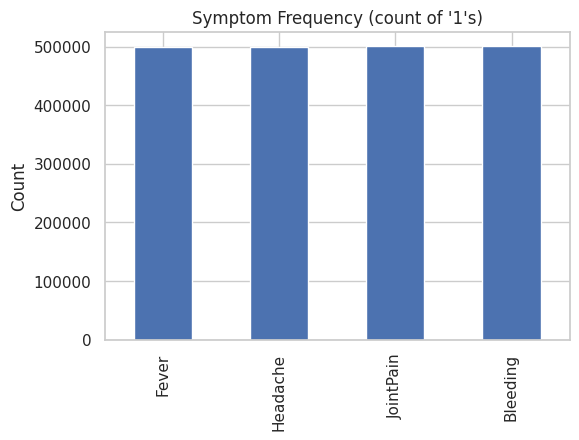

In [4]:
# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Info & missing values
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

# Show column list
print("\nColumns:", df.columns.tolist())

# Confirm expected columns exist and show target distribution
expected = ["Fever","Headache","JointPain","Bleeding","Dengue"]
for c in expected:
    if c not in df.columns:
        raise KeyError(f"Expected column '{c}' not found in dataset columns: {df.columns.tolist()}")

print("\nTarget (Dengue) distribution:")
print(df['Dengue'].value_counts(dropna=False))
print("\nTarget proportions:")
print(df['Dengue'].value_counts(normalize=True))

# Symptom frequency
symptoms = ["Fever","Headache","JointPain","Bleeding"]
print("\nSymptom counts:")
print(df[symptoms].sum())

# Quick bar plot for symptom frequencies
plt.figure(figsize=(6,4))
df[symptoms].sum().plot(kind="bar")
plt.title("Symptom Frequency (count of '1's)")
plt.ylabel("Count")
plt.show()


## Decide prediction task
Predict `Dengue` (binary: 1 = Dengue, 0 = No Dengue).  
We will treat the dataset as balanced (check proportions above); if highly imbalanced, consider class_weight or resampling strategies.


In [5]:
# Drop Name column (not useful)
if "Name" in df.columns:
    df = df.drop(columns=["Name"])

# Ensure binary columns are numeric 0/1
for c in ["Fever","Headache","JointPain","Bleeding","Dengue"]:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

# Features & target
X = df.drop("Dengue", axis=1)
y = df["Dengue"]

print("Feature columns:", X.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)


Feature columns: ['Fever', 'Headache', 'JointPain', 'Bleeding']
X shape: (1000000, 4) y shape: (1000000,)


## Feature selection & preprocessing plan
- Features: Fever, Headache, JointPain, Bleeding (all binary)
- No categorical encoding required
- Scale features (StandardScaler) — not strictly required for tree models but useful for NN
- Train/val/test split: 70% train, 15% validation, 15% test (stratified on target)
- Save scaler & feature list for inference


In [6]:
# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# Second split: validation (15%), test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Sizes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Scale numeric features (fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save scaler & feature list to Drive for inference
scaler_path = os.path.join(DRIVE_MODEL_DIR, "scaler_dengue.pkl")
joblib.dump(scaler, scaler_path)
feature_list = X.columns.tolist()
feat_file = os.path.join(DRIVE_MODEL_DIR, "feature_list_dengue.json")
with open(feat_file, "w") as f:
    json.dump(feature_list, f)
print("Saved scaler to:", scaler_path)
print("Saved feature list to:", feat_file)


Sizes -> Train: (700000, 4) Val: (150000, 4) Test: (150000, 4)
Saved scaler to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/scaler_dengue.pkl
Saved feature list to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/feature_list_dengue.json


## Baseline model: Logistic Regression
Train Logistic Regression as a simple, interpretable baseline.


In [7]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

# Validate
y_val_pred_lr = lr.predict(X_val_scaled)
y_val_proba_lr = lr.predict_proba(X_val_scaled)[:,1]
print("Validation report (Logistic Regression):")
print(classification_report(y_val, y_val_pred_lr))


Validation report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     75010
           1       0.50      0.50      0.50     74990

    accuracy                           0.50    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.50      0.50      0.50    150000



## Ensemble baseline: Random Forest
Train RandomForest as a strong baseline for tabular data.


In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Validate
y_val_pred_rf = rf.predict(X_val_scaled)
y_val_proba_rf = rf.predict_proba(X_val_scaled)[:,1]
print("Validation report (Random Forest):")
print(classification_report(y_val, y_val_pred_rf))

# Feature importances
feat_imp = pd.Series(rf.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\nFeature importances:\n", feat_imp)

# Save RF model
rf_path = os.path.join(DRIVE_MODEL_DIR, "rf_dengue.pkl")
joblib.dump(rf, rf_path)
print("Saved Random Forest to:", rf_path)


Validation report (Random Forest):
              precision    recall  f1-score   support

           0       0.50      0.57      0.53     75010
           1       0.50      0.44      0.47     74990

    accuracy                           0.50    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.50      0.50      0.50    150000


Feature importances:
 Bleeding     0.288771
Fever        0.266813
JointPain    0.244611
Headache     0.199805
dtype: float64
Saved Random Forest to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/rf_dengue.pkl


## Neural network (Keras)
Train a small dense neural network — useful as a second benchmark and production option.


In [9]:
tf.random.set_seed(42)
nn_version = "v1"

nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks: EarlyStopping & ModelCheckpoint
nn_model_file = os.path.join(DRIVE_MODEL_DIR, f"nn_dengue_{nn_version}.h5")
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mc = ModelCheckpoint(nn_model_file, monitor='val_loss', save_best_only=True)

history = nn.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                 epochs=50, batch_size=256, callbacks=[es, mc], verbose=2)

print("Best NN model saved to:", nn_model_file)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


2735/2735 - 14s - 5ms/step - accuracy: 0.5000 - loss: 0.6936 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 2/50


2735/2735 - 11s - 4ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 3/50


2735/2735 - 11s - 4ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 4/50
2735/2735 - 8s - 3ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 5/50
2735/2735 - 11s - 4ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 6/50


2735/2735 - 10s - 4ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 7/50


2735/2735 - 7s - 3ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 8/50
2735/2735 - 10s - 4ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 9/50
2735/2735 - 12s - 4ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 10/50
2735/2735 - 9s - 3ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 11/50
2735/2735 - 8s - 3ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 12/50
2735/2735 - 11s - 4ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 13/50
2735/2735 - 13s - 5ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Best NN model saved to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/nn_dengue_v1.h5


## Training curves for neural network
Plot training & validation accuracy and loss to check for overfitting.


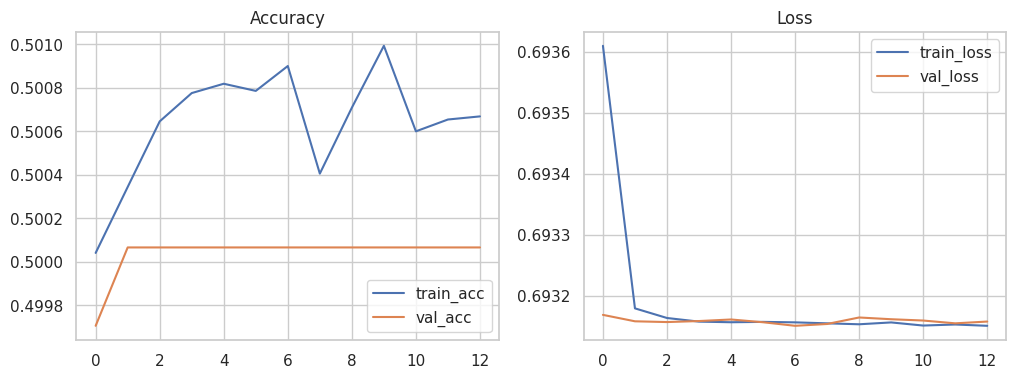

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()


## Evaluate the selected models on the TEST set
We will evaluate Logistic Regression, Random Forest, and the saved Neural Network on the reserved test set.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

=== Logistic Regression ===
Accuracy: 0.5007333333333334
Precision: 0.5006588492100464
Recall: 0.5016069023456774
F1: 0.5011324273914202
ROC AUC: 0.5002448262274887
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     75011
           1       0.50      0.50      0.50     74989

    accuracy                           0.50    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.50      0.50      0.50    150000



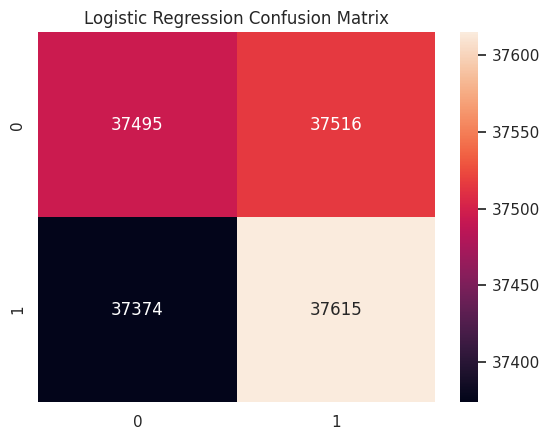


=== Random Forest ===
Accuracy: 0.50058
Precision: 0.5005756529115918
Recall: 0.4406512955233434
F1: 0.46870589570286736
ROC AUC: 0.5000317533340164
              precision    recall  f1-score   support

           0       0.50      0.56      0.53     75011
           1       0.50      0.44      0.47     74989

    accuracy                           0.50    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.50      0.50      0.50    150000



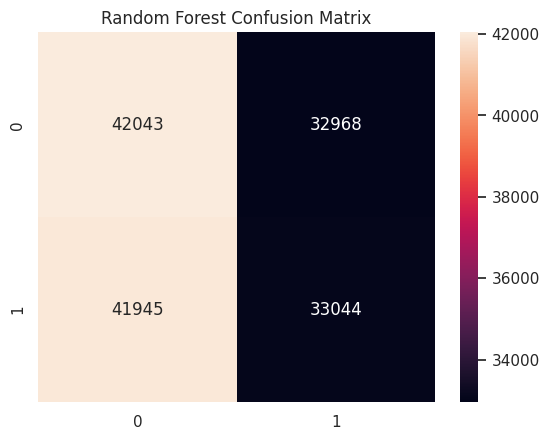


=== Neural Network ===
Accuracy: 0.5000733333333334
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC AUC: 0.5019706433312796
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     75011
           1       0.00      0.00      0.00     74989

    accuracy                           0.50    150000
   macro avg       0.25      0.50      0.33    150000
weighted avg       0.25      0.50      0.33    150000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


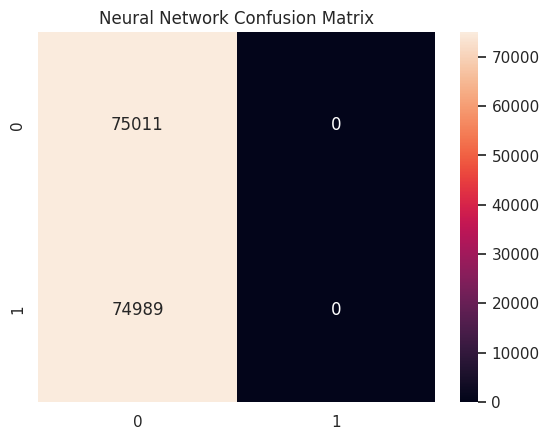

In [11]:
# Logistic Regression
y_test_pred_lr = lr.predict(X_test_scaled)
y_test_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

# Random Forest
y_test_pred_rf = rf.predict(X_test_scaled)
y_test_proba_rf = rf.predict_proba(X_test_scaled)[:,1]

# Neural Net - load best saved model
nn_loaded = tf.keras.models.load_model(nn_model_file)
y_test_proba_nn = nn_loaded.predict(X_test_scaled).ravel()
y_test_pred_nn = (y_test_proba_nn >= 0.5).astype(int)

# Utility to print metrics
def print_metrics(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    try:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
    except:
        print("ROC AUC: N/A")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d'); plt.title(model_name + " Confusion Matrix"); plt.show()

print_metrics(y_test, y_test_pred_lr, y_test_proba_lr, "Logistic Regression")
print_metrics(y_test, y_test_pred_rf, y_test_proba_rf, "Random Forest")
print_metrics(y_test, y_test_pred_nn, y_test_proba_nn, "Neural Network")


## Save model artifacts and metadata for integration
We will save:
- Logistic Regression model (`lr_dengue.pkl`)
- Random Forest model (`rf_dengue.pkl`)
- Neural network model (`nn_dengue_v1.h5`)
- Scaler (`scaler_dengue.pkl`)
- Feature list (`feature_list_dengue.json`)
- Metadata file describing the models & inputs
All saved into `DRIVE_MODEL_DIR`.


In [12]:
# Save logistic regression
lr_path = os.path.join(DRIVE_MODEL_DIR, "lr_dengue.pkl")
joblib.dump(lr, lr_path)
print("Saved Logistic Regression to:", lr_path)

# RF saved earlier to rf_path; NN saved to nn_model_file; scaler_path & feat_file saved earlier

# Save metadata
metadata = {
    "model_name": "dengue_classifier",
    "models": {
        "logistic_regression": os.path.basename(lr_path),
        "random_forest": os.path.basename(rf_path),
        "neural_network": os.path.basename(nn_model_file)
    },
    "features": feature_list,
    "target": "Dengue",
    "scaler": os.path.basename(scaler_path),
    "notes": "Binary classifier: 1 = Dengue, 0 = No Dengue. For research/demo use only."
}
meta_file = os.path.join(DRIVE_MODEL_DIR, "metadata_dengue.json")
with open(meta_file, "w") as f:
    json.dump(metadata, f, indent=2)
print("Saved metadata to:", meta_file)


Saved Logistic Regression to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/lr_dengue.pkl
Saved metadata to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/metadata_dengue.json


## Prediction helper function
This function will be used by the chatbot backend. It:
- Accepts a dictionary of raw inputs (feature_name -> value)
- Builds a DataFrame in the correct feature order
- Applies the scaler and chosen model
- Returns probability + label + human-friendly text


In [13]:
# Load artifacts for inference
scaler = joblib.load(scaler_path)
rf_model = joblib.load(rf_path)
lr_model = joblib.load(lr_path)
nn_model = nn_loaded
with open(feat_file, "r") as f:
    feature_list = json.load(f)

def prepare_input(raw_input: dict):
    row = {f: raw_input.get(f, 0) for f in feature_list}
    df_row = pd.DataFrame([row], columns=feature_list)
    df_row = df_row.fillna(0)
    arr = scaler.transform(df_row)
    return arr

def predict_dengue(raw_input: dict, model_type="rf"):
    arr = prepare_input(raw_input)
    if model_type == "rf":
        proba = float(rf_model.predict_proba(arr)[:,1][0])
    elif model_type == "lr":
        proba = float(lr_model.predict_proba(arr)[:,1][0])
    elif model_type == "nn":
        proba = float(nn_model.predict(arr).ravel()[0])
    else:
        raise ValueError("model_type must be one of ['rf','lr','nn']")
    label = int(proba >= 0.5)
    return {"probability": proba, "label": label, "label_text": ("Dengue" if label==1 else "No Dengue")}

# Test prediction
sample = {"Fever":1, "Headache":1, "JointPain":0, "Bleeding":0}
print("RF:", predict_dengue(sample, "rf"))
print("LR:", predict_dengue(sample, "lr"))
print("NN:", predict_dengue(sample, "nn"))


RF: {'probability': 0.5024397610054661, 'label': 1, 'label_text': 'Dengue'}
LR: {'probability': 0.5012456652966596, 'label': 1, 'label_text': 'Dengue'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
NN: {'probability': 0.4984193444252014, 'label': 0, 'label_text': 'No Dengue'}


## FastAPI snippet — serve the model as HTTP endpoint for chatbot integration
Save this as `app.py` in your backend. The chatbot will call `/predict` with JSON payload containing features and optional model_type.


In [14]:
fastapi_snippet = f'''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, pandas as pd, tensorflow as tf

app = FastAPI()

# Update these paths if different in production
SCALER_PATH = "{scaler_path}"
RF_PATH = "{rf_path}"
LR_PATH = "{lr_path}"
NN_PATH = "{nn_model_file}"
FEATURES_PATH = "{feat_file}"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
lr = joblib.load(LR_PATH)
nn = tf.keras.models.load_model(NN_PATH)
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)

class Query(BaseModel):
    data: dict
    model_type: str = "rf"

def prepare_input_row(raw_input):
    row = {{f: raw_input.get(f, 0) for f in features}}
    df_row = pd.DataFrame([row], columns=features)
    df_row = df_row.fillna(0)
    arr = scaler.transform(df_row)
    return arr

@app.post("/predict")
def predict(query: Query):
    arr = prepare_input_row(query.data)
    if query.model_type == "rf":
        proba = float(rf.predict_proba(arr)[:,1][0])
    elif query.model_type == "lr":
        proba = float(lr.predict_proba(arr)[:,1][0])
    elif query.model_type == "nn":
        proba = float(nn.predict(arr).ravel()[0])
    else:
        return {{"error":"unknown model_type"}}
    label = int(proba >= 0.5)
    return {{"probability": proba, "label": label, "label_text": ("Dengue" if label else "No Dengue")}}
'''
print(fastapi_snippet)



from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, pandas as pd, tensorflow as tf

app = FastAPI()

# Update these paths if different in production
SCALER_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/scaler_dengue.pkl"
RF_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/rf_dengue.pkl"
LR_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/lr_dengue.pkl"
NN_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/nn_dengue_v1.h5"
FEATURES_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/dengue_classifier/feature_list_dengue.json"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
lr = joblib.load(LR_PATH)
nn = tf.keras.models.load_model(NN_PATH)
with open(FEATURES_PATH, 'r') as f:
    features = json.load(f)

class Query(BaseModel):
    data: dict
    model_type: str = "rf"

def prepare_input_row(raw_input):
    row = {f: raw_input.get(f, 

## Upload model artifacts to Hugging Face Hub (optional)
Use this code to push your saved artifacts (`.pkl`, `.h5`, `scaler`, README) into a HF model repo.
You need a Hugging Face token (store it in an environment variable or paste it during login).
This function is reusable across notebooks — call `upload_to_hf(local_dir, repo_id, hf_token)`.


In [15]:
# Hugging Face upload helper
from huggingface_hub import HfApi, HfFolder, Repository

def upload_to_hf(local_dir, repo_id, hf_token, commit_message="Initial model upload"):
    """
    local_dir: local directory containing model artifacts + README.md
    repo_id: "your-username/repo-name"
    hf_token: your huggingface token (string)
    """
    # Save token so Repository can use it
    HfFolder.save_token(hf_token)

    api = HfApi()
    try:
        api.create_repo(repo_id=repo_id, exist_ok=True, token=hf_token)
        print("Repo created/ready:", repo_id)
    except Exception as e:
        print("Repo create/exists:", e)

    # Use Repository to push (it will clone the remote)
    repo = Repository(local_dir, clone_from=repo_id, use_auth_token=hf_token)
    repo.push_to_hub(commit_message=commit_message)
    print("Uploaded to HF repo:", repo_id)

# Prepare local folder to upload
import shutil, glob
local_dir = "hf_dengue_model"
if os.path.exists(local_dir):
    shutil.rmtree(local_dir)
os.makedirs(local_dir, exist_ok=True)

# Copy artifacts into local_dir
for p in [lr_path, rf_path, nn_model_file, scaler_path, feat_file, meta_file]:
    if os.path.exists(p):
        shutil.copy(p, local_dir)

# Create README
with open(os.path.join(local_dir, "README.md"), "w") as f:
    f.write("# Dengue Classifier\n\nModel artifacts for Dengue classifier (symptom-based).")

print("Local HF folder prepared at:", local_dir)
print("When ready, call: upload_to_hf(local_dir, 'your-username/dengue-classifier', hf_token='hf_xxx')")


Local HF folder prepared at: hf_dengue_model
When ready, call: upload_to_hf(local_dir, 'your-username/dengue-classifier', hf_token='hf_xxx')


## Integration notes for the chatbot
- **Endpoint**: `POST /predict`
- **Payload**: `{ "data": {"Fever":1,"Headache":1,"JointPain":0,"Bleeding":0}, "model_type": "rf" }`
- **Response**: `{ "probability": 0.87, "label": 1, "label_text": "Dengue" }`

Best practices:
- Show model confidence and clinical disclaimer.
- If probability near 0.5, ask follow-up questions or escalate to a human clinician.
- Log queries & model outputs (anonymized) for retraining.


## Next steps & model improvements
1. Add more symptom / lab features (platelet count, NS1 test) to improve signal.  
2. Add clinical question-flow in chatbot to gather additional context before calling model.  
3. Add SHAP explainability for instance-level explanations to show which symptoms contributed.  
4. Consider multi-disease model later (typhoid vs dengue vs malaria) using merged datasets.  
5. For production deploy model on a secure server or HF Inference Endpoint and protect the API with auth.


### Final notes
- Keep `dengue.csv`, `scaler_dengue.pkl`, `feature_list_dengue.json`, `metadata_dengue.json`, and model files together in `DRIVE_MODEL_DIR`.  
- Reuse the Hugging Face upload helper across other notebooks (typhoid, liver etc.) by copying the helper cell.  
- For very large dataset training (1M rows), consider training on a VM with more RAM / GPUs or downsampling for quick iteration.
